In [15]:
# %%
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

In [16]:
# %%
data_path = Path("../data/processed/istdata_clean.parquet")

# LazyFrame öffnen – scan_parquet lädt NICHT in RAM
lf = pl.scan_parquet(data_path)

# Schema anzeigen (optional)
lf.collect_schema()

Schema([('BETRIEBSTAG', String),
        ('BETREIBER_NAME', String),
        ('PRODUKT_ID', Categorical),
        ('LINIEN_TEXT', String),
        ('HALTESTELLEN_NAME', String),
        ('ANKUNFTSZEIT', Datetime(time_unit='ns', time_zone='UTC')),
        ('ABFAHRTSZEIT', Datetime(time_unit='ns', time_zone='UTC')),
        ('delay_arrival_s', Float64),
        ('delay_departure_s', Float64),
        ('on_time', Boolean),
        ('FAELLT_AUS_TF', Boolean),
        ('BPUIC', String)])

In [17]:
# %%
lf_zrh = (
    lf
    .filter(pl.col("BPUIC") == "8503000")       # Zürich HB
    .with_columns([
        # Datum aus String
        pl.col("BETRIEBSTAG")
            .str.strptime(pl.Date, "%d.%m.%Y", strict=False)
            .alias("date"),

        # Stunde der Ankunft
        pl.col("ANKUNFTSZEIT").dt.hour().alias("hour"),

        # Wochentag als Text
        pl.col("BETRIEBSTAG")
            .str.strptime(pl.Date, "%d.%m.%Y", strict=False)
            .dt.strftime("%A")
            .alias("weekday"),

        # delay in Minuten
        (pl.col("delay_arrival_s") / 60).alias("delay_min"),
    ])
)

lf_zrh

In [18]:
# %%
df = lf_zrh.select(["weekday", "hour", "delay_min"]).collect()

print(df.shape)
df.head()

(66865, 3)


weekday,hour,delay_min
str,i8,f64
"""Monday""",10,4.283333
"""Monday""",6,0.2
"""Monday""",7,1.766667
"""Monday""",null,1.15
"""Monday""",null,1.15


In [20]:
# %%
df_grouped = (
    df
    .group_by(["weekday", "hour"])
    .agg(pl.col("delay_min").mean().alias("mean_delay"))
    .sort(["weekday", "hour"])
)

df_pivot = df_grouped.pivot(
    values="mean_delay",
    index="weekday",
    on="hour"
).sort("weekday")

df_pivot.head()

weekday,null,0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,3
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Friday""",1.15,3.986237,3.759259,0.933333,1.204167,0.50473,0.705059,1.561304,2.211348,1.428168,1.362204,0.796181,1.21772,0.904088,1.073961,1.140495,1.913506,1.923043,1.390067,1.21972,1.627763,1.064665,2.05658,1.307544,null
"""Monday""",1.15,1.303045,1.217647,null,1.16,0.599369,1.11056,1.528695,2.055471,1.375244,2.210036,0.936422,0.871766,0.602867,0.936915,0.722714,1.274807,1.904974,1.327899,0.99,1.891357,1.298833,1.662228,1.008357,null
"""Saturday""",1.15,0.434505,1.795714,1.018678,1.566667,0.384274,0.545566,0.41978,1.746788,0.834211,0.635602,0.812838,0.911453,0.816204,0.793884,0.721322,0.870056,0.835051,1.335258,0.821296,0.610019,0.913145,1.080389,0.602872,0.396774
"""Sunday""",1.15,0.412155,0.161275,0.276316,0.690873,0.377222,0.292492,0.248056,0.860399,0.699265,0.655817,0.609484,0.758054,0.604015,0.548599,0.63188,0.927918,0.921689,0.897245,1.031612,0.930359,0.838773,0.91437,0.582937,0.281989
"""Thursday""",1.15,1.266159,0.970833,null,1.354167,0.726351,0.744505,1.779552,1.976627,1.263263,0.850546,0.573984,1.01837,0.727853,0.932461,1.239173,1.262871,1.657372,1.475539,1.20641,1.549954,1.300302,1.251766,1.066189,null


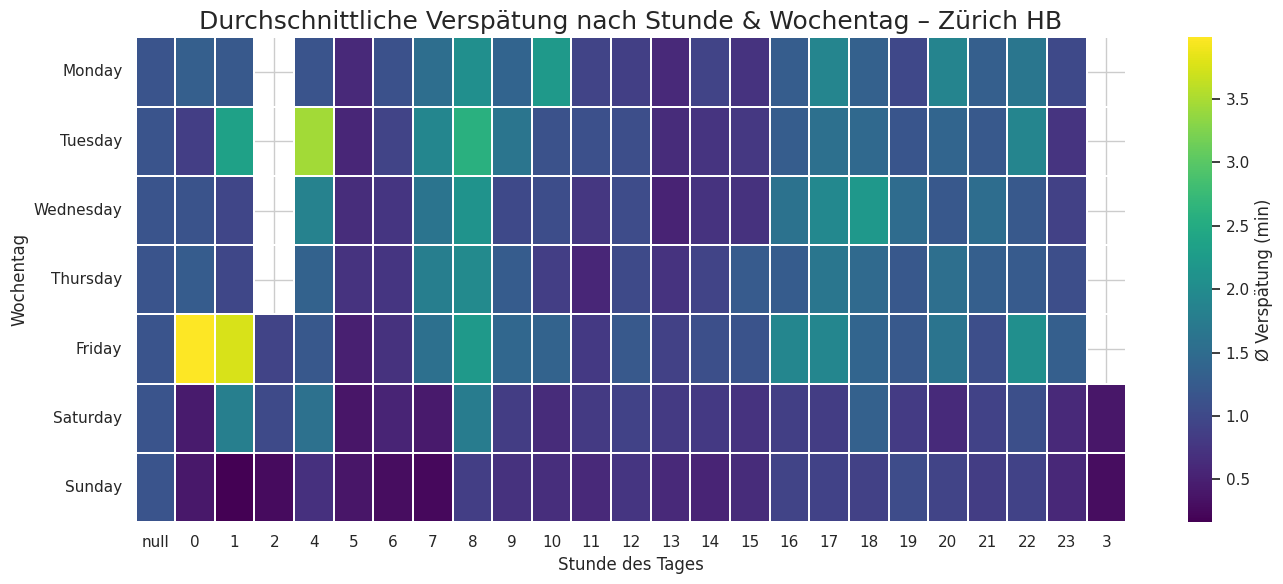

In [23]:
# %%
# Für Heatmap: weekday als Index setzen und nur numerische Spalten verwenden
# Wochentage in der richtigen Reihenfolge sortieren
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df_pivot_pandas = (
    df_pivot.to_pandas()
    .set_index("weekday")
    .reindex(weekday_order)
)

plt.figure(figsize=(14, 6))
sns.heatmap(
    df_pivot_pandas,
    cmap="viridis",
    linewidths=0.3,
    linecolor="white",
    cbar_kws={"label": "Ø Verspätung (min)"}
)

plt.title("Durchschnittliche Verspätung nach Stunde & Wochentag – Zürich HB", fontsize=18)
plt.xlabel("Stunde des Tages")
plt.ylabel("Wochentag")

plt.tight_layout()
plt.show()